In [1]:
import os
import numpy as np
import warnings
from lmfit import Model
import pandas as pd
from final_scripts.get_data import OUTPUT_PATH
import matplotlib.pyplot as plt
import seaborn as sns
from final_scripts.curve_fitter import *


In [2]:
# Turn off warnings
warnings.filterwarnings('ignore')
# Import ART coverage data
artDf = pd.read_csv(os.path.join(OUTPUT_PATH, 'API_SH.HIV.ARTC.ZS_DS2_EN_csv_v2_116032.csv'), header=2)
artDf.drop(labels=['Indicator Name', 'Indicator Code', 'Unnamed: 22'], axis=1, inplace=True)
# Import population coverage data
popDf = pd.read_csv(os.path.join(OUTPUT_PATH, 'API_SP.POP.TOTL_DS2_EN_csv_v2_116033.csv'), header=2)
popList = popDf[popDf['2017']>=1e6]['Country Code'].tolist()
# Import data to get countries in sub-Saharan Africa (World Bank GroupCode = SSF)
classDf = pd.read_excel(os.path.join(OUTPUT_PATH, 'WB_Classification.xls'), sheet_name='Groups')
ssfCountries = classDf[classDf['GroupCode']=='SSF']['CountryCode'].tolist()
countryList = list(set(popList) & set(ssfCountries))
countryList.sort()

In [3]:
resultsDict = {'logistic':{}, 'gompertz':{}, 'constants':{}}
modelDict = {}
for country in ssfCountries:
    print(f'Fitting curves for {country}')
    df = artDf[artDf['Country Code'] == country]
    # Get time values
    tStr = [col for col in df if col.startswith('20')]
    # Center around 2000
    tInt = [int(t) - 2000 for t in tStr]
    # Get coverage values
    y = np.asarray(df[tStr])
    if np.isnan(np.sum(y)):
        print(f'Skipping {country}, contains NaN values.')
        continue
    # Fit logistic curve
    logisticFit = curveFitter(function=logistic, y=y, t=tInt)
    # Fit Gompertz curve
    gompertzFit = curveFitter(function=gompertz, y=y, t=tInt)
    if country in ['BWA','GAB','RWA','KEN','UGA','ZAF']:
        modelDict[country] = {'logistic': logisticFit, 'gompertz': gompertzFit}
    # Store results
    resultsDict['logistic'][country] = storeResults(logisticFit)
    resultsDict['gompertz'][country] = storeResults(gompertzFit)
    resultsDict['constants'][country] = storeConstants(y)

Fitting curves for AGO
Fitting curves for BDI
Fitting curves for BEN
Fitting curves for BFA
Fitting curves for BWA
Fitting curves for CAF
Fitting curves for CIV
Fitting curves for CMR
Fitting curves for COD
Fitting curves for COG
Fitting curves for COM
Fitting curves for CPV
Fitting curves for ERI
Fitting curves for ETH
Fitting curves for GAB
Fitting curves for GHA
Fitting curves for GIN
Fitting curves for GMB
Fitting curves for GNB
Fitting curves for GNQ
Fitting curves for KEN
Fitting curves for LBR
Fitting curves for LSO
Fitting curves for MDG
Fitting curves for MLI
Fitting curves for MOZ
Fitting curves for MRT
Fitting curves for MUS
Skipping MUS, contains NaN values.
Fitting curves for MWI
Fitting curves for NAM
Fitting curves for NER
Fitting curves for NGA
Fitting curves for RWA
Fitting curves for SDN
Fitting curves for SEN
Fitting curves for SLE
Fitting curves for SOM
Fitting curves for SSD
Fitting curves for STP
Skipping STP, contains NaN values.
Fitting curves for SWZ
Fitting cu

In [7]:
def makeCountrySubplots(artDf, countries, model_dict, output_path, show_plot=False):
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='none', figsize=(13, 15))
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    sns.set_style('darkgrid')
    t2 = np.asarray(range(0, 26))

    for ax, country in zip(axes, countries):
        # ART coverage data
        df = artDf[artDf['Country Code'] == country]
        # Get time values
        t = [int(col)-2000 for col in df if col.startswith('20')]
        tStr = [col for col in df if col.startswith('20')]
        y = df[tStr].values.tolist()[0]
        ax.plot(t, y, 'bs')
        ax.plot(t2, model_dict[country]['gompertz'].eval(t=t2), 'r-')
        ax.plot(t2, model_dict[country]['logistic'].eval(t=t2), 'g--')
        ax.set_xlim([0, 20])
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end + 1, 5))
        ax.xaxis.set_ticklabels(['2000', '2005', '2010', '2015', '2020'], fontsize=12)
        ax.set_xlabel(df['Country Name'].iloc[0], fontsize=13)
        if ax in [ax1, ax3, ax5]:
            ax.set_ylabel('% ART Coverage', fontsize=13)
        plt.rc('ytick', labelsize=12)

    ax4.legend(['Data', 'Gompertz', 'Logistic'], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0.5)
    if show_plot:
        plt.show()

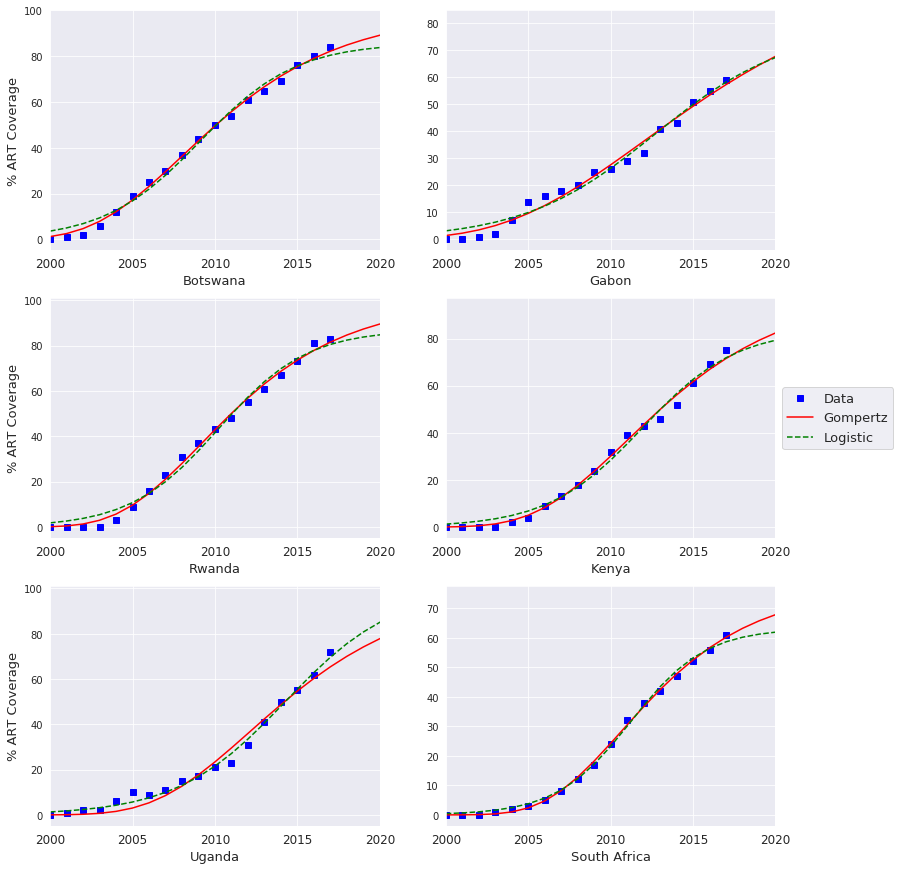

In [8]:
makeCountrySubplots(artDf,
                    countries=['BWA','GAB','RWA','KEN','UGA','ZAF'],
                    model_dict=modelDict, 
                    output_path=False, show_plot=True)

In [ ]:
# TODO: Test caterpillar plots
def makeCaterpillarPlot(df, xlabel, output_path, show_plot=False):
    """
    Make caterpillar plot of estimate parameter values
    :param df: Melted dataframe for single group of metrics
    :param xlabel: Label for x-axis of output graph
    :param output_path: Path to store output graph
    :param show_plot: (Optional) Show output graph prior to storing
    :return:
    """
    # TODO: add error bars around estimates and jitter values
    ax = sns.stripplot(x='Value', y='Country Name',
                       data=df.sort_values(by=['Metric', 'Value'], ascending=[True, False]), hue='Metric', size=9)
    fig = ax.get_figure()
    ax.set_ylabel('')
    ax.set_xlabel(xlabel, fontsize=16)
    fig.set_size_inches((10, 12))
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='x', labelsize=16)
    ax.legend(fontsize=14, loc=7, frameon=True, facecolor='white')
    if show_plot:
        plt.show()
    if output_path:
        fig.savefig(output_path,dpi=300,bbox_inches='tight')



In [9]:
dfDict = {func: pd.DataFrame.from_dict(resultsDict[func], orient='index') for func in resultsDict.keys()}
joinedDf = pd.merge(left=dfDict['logistic'], right=dfDict['gompertz'], how='left',
                    left_index=True, right_index=True, suffixes=('_logistic', '_gompertz'))
joinedDf = pd.merge(left=joinedDf, right=dfDict['constants'], how='left',
                    left_index=True, right_index=True)
joinedDf['delta_BIC'] = joinedDf['BIC_gompertz']-joinedDf['BIC_logistic']
joinedDf = pd.merge(left=joinedDf, right=artDf[['Country Code','Country Name']], how='left',
                    left_index=True, right_on='Country Code')

# Add rankings based on subset of metrics
for metric in ['avgChange','mu_gompertz','mu_logistic']:
    joinedDf['rank_'+metric] = joinedDf[metric].rank(ascending=False, method='min')

for metric in ['obsDelay', 'lamb_gompertz', 'lamb_logistic']:
    joinedDf['rank_'+metric] = joinedDf[metric].rank(ascending=True, method='min')

In [ ]:
joinedDf.columns

In [ ]:
mu_df=pd.melt(joinedDf,id_vars='Country Name',value_vars=['mu_gompertz','mu_logistic','avgChange'],
                var_name='Metric',value_name='Value')


In [ ]:
mu_df.replace({'Metric':{'mu_gompertz':'$\mu$ - Gompertz','mu_logistic':'$\mu$ - Logistic',
                'avgChange':'Avg. change'}},inplace=True)

In [ ]:
sns.set()
ax=sns.stripplot(x='Value',y='Country Name',data=mu_df.sort_values(by=['Metric','Value'],ascending=[True,False]),
                 hue='Metric',size=9)
fig=ax.get_figure()
ax.set_ylabel('')
ax.set_xlabel('Rate of change',fontsize=16)
fig.set_size_inches((10,12))
ax.tick_params(axis='y',labelsize=13)
ax.tick_params(axis='x',labelsize=16)
ax.legend(fontsize=14,loc=7,frameon=True,facecolor='white')
plt.show()




In [10]:
lamb_df=pd.melt(joinedDf,id_vars='Country Name',value_vars=['lamb_gompertz','lamb_logistic','obsDelay'],
                var_name='Metric',value_name='Value')
lamb_df.replace({'Metric':{'lamb_gompertz':'$\lambda$ - Gompertz','lamb_logistic':'$\lambda$ - Logistic',
                              'obsDelay':'Observed'}},inplace=True)


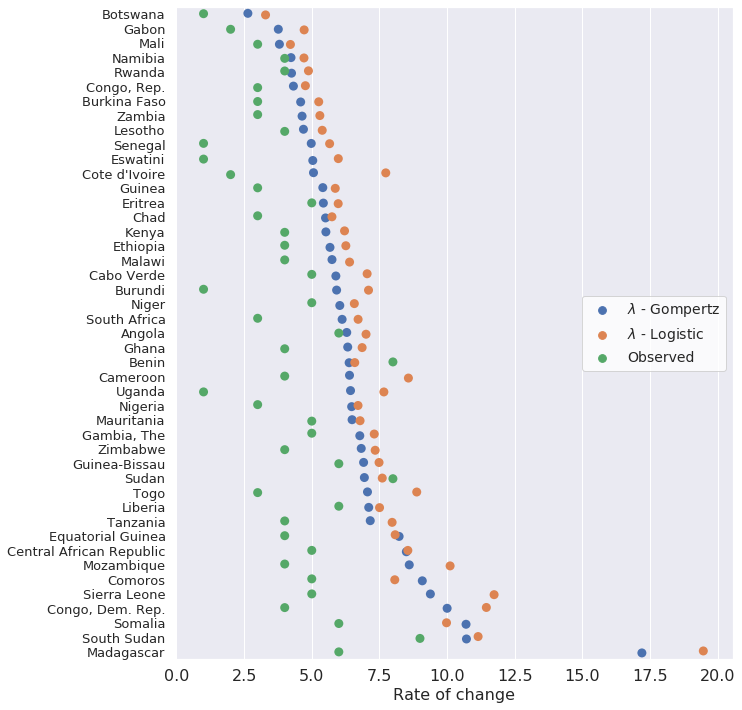

In [16]:
sns.set()
ax=sns.stripplot(x='Value',y='Country Name',data=lamb_df.sort_values(by=['Metric','Value'],ascending=[True,True]),
                 hue='Metric',size=9)
fig=ax.get_figure()
ax.set_ylabel('')
ax.set_xlabel('Rate of change',fontsize=16)
fig.set_size_inches((10,12))
ax.tick_params(axis='y',labelsize=13)
ax.tick_params(axis='x',labelsize=16)
ax.legend(fontsize=14,loc=7,frameon=True,facecolor='white')
plt.show()

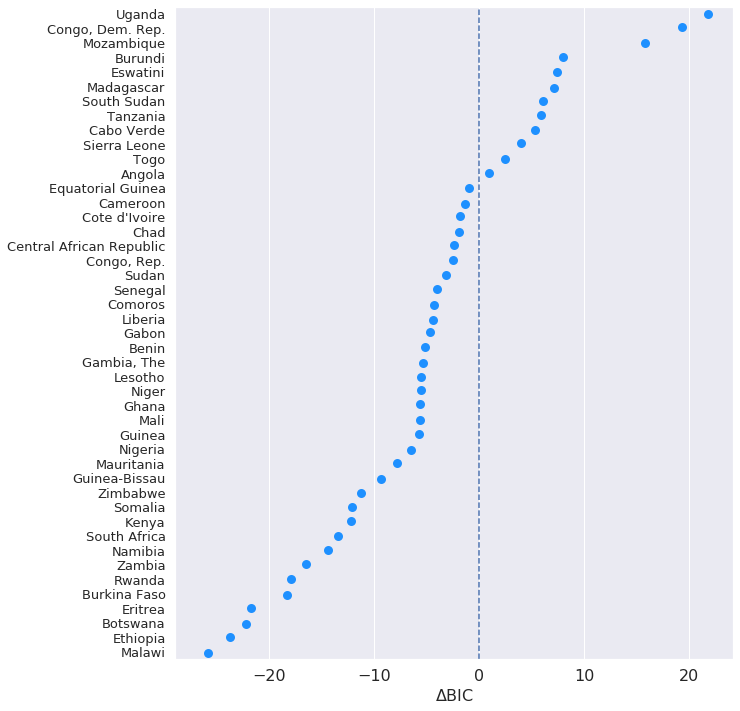

In [13]:
ax=sns.stripplot(x='delta_BIC',y='Country Name',data=joinedDf.sort_values(by='delta_BIC',ascending=False),
                 color='dodgerblue',size=9)
fig=ax.get_figure()
ax.set_ylabel('')
ax.set_xlabel('$\Delta$BIC',fontsize=16)
fig.set_size_inches((10,12))
ax.tick_params(axis='y',labelsize=13)
ax.tick_params(axis='x',labelsize=16)
plt.axvline(x=0,ls='--')
plt.show()